In [ ]:
#this code is referenced from the official tutorial

# Instance Segmentation

In this tutorial, you will learn:
- to perform inference with a MMDetection detector.
- to train a new instance segmentation model with a new dataset.
  
Please first go through the MMDet_Detection_Tutorial if you havent

In [3]:
cd mmdetection

/home/test/MMdet/mmdetection


In [2]:
# there are plenty of models
# you may check what models are available on
# https://mmdetection.readthedocs.io/en/latest/modelzoo_statistics.html
# only part of the models support instance segmentation
# you can check the .py to confirm
# for example, in
# https://github.com/open-mmlab/mmdetection/tree/main/configs/atss
# the base config point to atss_r50_fpn_1x_coco.py
# we can find "bbox_head" but not "mask_head"
# so this model does not support instance segmentation
# in
# https://github.com/open-mmlab/mmdetection/tree/main/configs/mask_rcnn
# the base config point to mask-rcnn_r50_fpn.py
# we can find both "bbox_head" and "mask_head"
# so the model supports instance segmentation
# you can utilize the search function in your computer file browser to find the config

# or run the below code to inspect what kind of models are available

In [3]:
import os

base_dir = "./configs"
matched_files = []

for root, _, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".py"):
            file_path = os.path.join(root, file)
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()
                if "bbox_head" in content and "mask_head" in content:
                    matched_files.append(file_path)

# Print results
for path in matched_files:
    print(path)

# the results show condinst, yolact, mask-rcnn, etc 

./configs/condinst/condinst_r50_fpn_ms-poly-90k_coco_instance.py
./configs/yolact/yolact_r50_1xb8-55e_coco.py
./configs/yolact/.ipynb_checkpoints/yolact_r50_1xb8-55e_coco-checkpoint.py
./configs/gn+ws/mask-rcnn_r50_fpn_gn-ws-all_2x_coco.py
./configs/lvis/mask-rcnn_r50_fpn_sample1e-3_ms-1x_lvis-v1.py
./configs/lvis/mask-rcnn_r50_fpn_sample1e-3_ms-2x_lvis-v0.5.py
./configs/deepfashion/mask-rcnn_r50_fpn_15e_deepfashion.py
./configs/cityscapes/mask-rcnn_r50_fpn_1x_cityscapes.py
./configs/_base_/models/cascade-mask-rcnn_r50_fpn.py
./configs/_base_/models/mask-rcnn_r50-caffe-c4.py
./configs/_base_/models/mask-rcnn_r50_fpn.py
./configs/_base_/models/.ipynb_checkpoints/cascade-mask-rcnn_r50_fpn-checkpoint.py
./configs/_base_/models/.ipynb_checkpoints/mask-rcnn_r50_fpn-checkpoint.py
./configs/masktrack_rcnn/masktrack-rcnn_mask-rcnn_r50_fpn_8xb1-12e_youtubevis2019.py
./configs/strong_baselines/mask-rcnn_r50-caffe_fpn_rpn-2conv_4conv1fc_syncbn-all_lsj-100e_coco.py
./configs/strong_baselines/mask-

In [4]:
# load the pre-trained model
import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmengine import Config

# Load config file for the model
config_file = './configs/cascade_rcnn/cascade-mask-rcnn_r50_fpn_1x_coco.py'
config = Config.fromfile(config_file)
# Initialize detector with pre-trained weights, we just downloaded
checkpoint_file = './checkpoint/cascade_mask_rcnn_r50_fpn_1x_coco_20200203-9d4dcb24.pth'

# build the model from a config file and a checkpoint file
model = init_detector(config, checkpoint_file, device='cuda') 


Loads checkpoint by local backend from path: ./checkpoint/cascade_mask_rcnn_r50_fpn_1x_coco_20200203-9d4dcb24.pth


In [5]:
# Use the detector to do inference
image = mmcv.imread('demo/demo.jpg',channel_order='rgb')
result = inference_detector(model, image)
print(result)

<DetDataSample(

    META INFORMATION
    pad_shape: (800, 1216)
    img_path: None
    batch_input_shape: (800, 1216)
    scale_factor: (1.8734375, 1.873536299765808)
    img_id: 0
    ori_shape: (427, 640)
    img_shape: (800, 1199)

    DATA FIELDS
    ignored_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            labels: tensor([], device='cuda:0', dtype=torch.int64)
            masks: BitmapMasks(num_masks=0, height=427, width=640)
            bboxes: tensor([], device='cuda:0', size=(0, 4))
        ) at 0x71c2c527af80>
    gt_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            labels: tensor([], device='cuda:0', dtype=torch.int64)
            masks: BitmapMasks(num_masks=0, height=427, width=640)
            bboxes: tensor([], device='cuda:0', size=(0, 4))
        ) at 0x71c2c527afb0>
    pred_instances: <InstanceData(
        
            META INFORMATION
        
     

/home/test/MMdet/mmdetection/mmdet/models/roi_heads/mask_heads/fcn_mask_head.py:339: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  mask_preds = bboxes.new_tensor(mask_preds)


### Let's plot the result

In [6]:
from mmdet.registry import VISUALIZERS
# init visualizer(run the block only once in jupyter notebook)
visualizer = VISUALIZERS.build(model.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer.dataset_meta = model.dataset_meta

/home/test/MMdet/mmengine/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


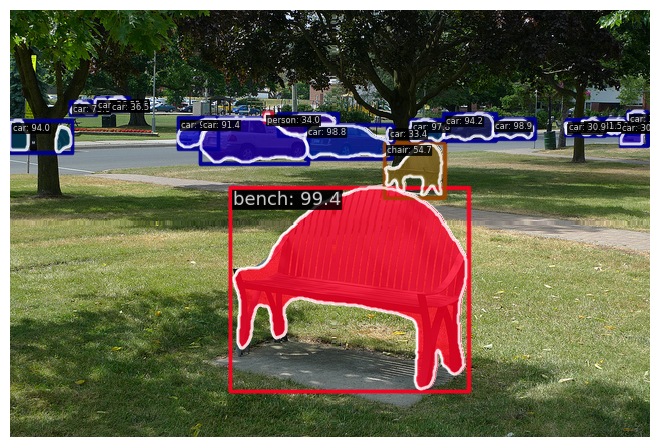

In [7]:
# show the results
visualizer.add_datasample(
    'result',
    image,
    data_sample=result,
    draw_gt = None,
    wait_time=0,
)
visualizer.show()

## Train a Detector on A Customized Dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Support a new dataset

There are three ways to support a new dataset in MMDetection:
  1. Reorganize the dataset into a COCO format
  2. Reorganize the dataset into a middle format
  3. Implement a new dataset

We recommend the first two methods, as they are usually easier than the third.

In this tutorial, we give an example that converts the data into COCO format because MMDetection **only support evaluating mask AP of dataset in COCO format for now**. Other methods and more advanced usages can be found in the [doc](https://mmdetection.readthedocs.io/en/latest/advanced_guides/customize_dataset.html).

We continue using the balloon dataset to demo

In [6]:
import os.path as osp
import mmcv
from mmengine.fileio import dump, load
from mmengine.utils import track_iter_progress

def convert_balloon_to_coco(ann_file, out_file, image_prefix):
    data_infos = load(ann_file)

    annotations = []
    images = []
    obj_count = 0
    data_infos = list(data_infos.values())
    for idx, v in enumerate(track_iter_progress(data_infos)):
        filename = v['filename']
        img_path = osp.join(image_prefix, filename)
        height, width = mmcv.imread(img_path).shape[:2]

        images.append(
            dict(id=idx, file_name=filename, height=height, width=width))

        for _, obj in v['regions'].items():
            assert not obj['region_attributes']
            obj = obj['shape_attributes']
            px = obj['all_points_x']
            py = obj['all_points_y']
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            x_min, y_min, x_max, y_max = (min(px), min(py), max(px), max(py))

            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=0,
                bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                area=(x_max - x_min) * (y_max - y_min),
                segmentation=[poly],
                iscrowd=0)
            annotations.append(data_anno)
            obj_count += 1

    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=[{
            'id': 0,
            'name': 'balloon'
        }])
    dump(coco_format_json, out_file)

convert_balloon_to_coco(ann_file='data/balloon/train/via_region_data.json',
                        out_file='data/balloon/train.json',
                        image_prefix='data/balloon/train')
convert_balloon_to_coco(ann_file='data/balloon/val/via_region_data.json',
                        out_file='data/balloon/val.json',
                        image_prefix='data/balloon/val')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 61/61, 132.1 task/s, elapsed: 0s, ETA:     0s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 13/13, 128.0 task/s, elapsed: 0s, ETA:     0s


### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [7]:
from mmengine import Config
cfg = Config.fromfile('./configs/cascade_rcnn/cascade-mask-rcnn_r50_fpn_1x_coco.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
auto_scale_lr = dict(base_batch_size=16, enable=False)
backend_args = None
data_root = 'data/coco/'
dataset_type = 'CocoDataset'
default_hooks = dict(
    checkpoint=dict(interval=1, type='CheckpointHook'),
    logger=dict(interval=50, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='DetVisualizationHook'))
default_scope = 'mmdet'
env_cfg = dict(
    cudnn_benchmark=False,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
load_from = None
log_level = 'INFO'
log_processor = dict(by_epoch=True, type='LogProcessor', window_size=50)
model = dict(
    backbone=dict(
        depth=50,
        frozen_stages=1,
        init_cfg=dict(checkpoint='torchvision://resnet50', type='Pretrained'),
        norm_cfg=dict(requires_grad=True, type='BN'),
        norm_eval=True,
        num_stages=4,
        out_

Given a config that trains a Cascade Mask R-CNN on COCO dataset, we need to modify some values to use it for training on the balloon dataset.

In [8]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('balloon', ), # names of classes
    'palette': [
        (220, 20, 60),
    ]
}

# Modify dataset type and path
cfg.data_root = 'data/balloon/'

cfg.train_dataloader.dataset.ann_file = 'train.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'val.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'val/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader = cfg.val_dataloader

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'/'+'val.json'
cfg.test_evaluator = cfg.val_evaluator

# Modify num classes of the model in box head and mask head
for head in cfg.model.roi_head.bbox_head:
    head.num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# We can use the pre-trained Mask RCNN model to obtain a higher performance
cfg.load_from = './checkpoint/cascade_mask_rcnn_r50_fpn_1x_coco_20200203-9d4dcb24.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# We can set the evaluation interval to reduce the evaluation times
cfg.train_cfg.val_interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.default_hooks.checkpoint.interval = 3

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optim_wrapper.optimizer.lr = 0.02 / 8
cfg.default_hooks.logger.interval = 10


# Set seed thus the results are more reproducible
# cfg.seed = 0
set_random_seed(0, deterministic=False)

# We can also use tensorboard to log the training process
cfg.visualizer.vis_backends.append({"type":'TensorboardVisBackend'})

#------------------------------------------------------
config=f'./configs/cascade_rcnn/cascade-mask-rcnn_r50_fpn_1x_balloon.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [9]:
%run tools/train.py {config}

05/21 10:45:38 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 209652396
    GPU 0: NVIDIA GeForce RTX 5090
    CUDA_HOME: /usr/local/cuda-12.8/
    NVCC: Cuda compilation tools, release 12.8, V12.8.93
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.8.0.dev20250422+cu128
    PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=c

2025-05-21 10:45:39.371050: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 10:45:39.518447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747795539.567138   17703 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747795539.584142   17703 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747795539.709105   17703 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

05/21 10:45:41 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
05/21 10:45:41 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/test/MMdet/mmengine/mmengine/logging/message_hub.py:346: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/aten/src/ATen/native/Scalar.cpp:22.)
  value = value.item()


05/21 10:45:45 - mmengine - INFO - Epoch(train)  [1][10/31]  lr: 4.7545e-05  eta: 0:01:16  time: 0.2105  data_time: 0.0242  memory: 4683  loss: 2.9307  loss_rpn_cls: 0.0750  loss_rpn_bbox: 0.0114  s0.loss_cls: 0.6949  s0.acc: 67.7734  s0.loss_bbox: 0.0405  s0.loss_mask: 0.9576  s1.loss_cls: 0.3909  s1.acc: 66.5039  s1.loss_bbox: 0.0343  s1.loss_mask: 0.3499  s2.loss_cls: 0.1503  s2.acc: 74.7070  s2.loss_bbox: 0.0246  s2.loss_mask: 0.2013
05/21 10:45:46 - mmengine - INFO - Epoch(train)  [1][20/31]  lr: 9.7595e-05  eta: 0:00:59  time: 0.1703  data_time: 0.0171  memory: 4688  loss: 2.6327  loss_rpn_cls: 0.0500  loss_rpn_bbox: 0.0102  s0.loss_cls: 0.6071  s0.acc: 85.7422  s0.loss_bbox: 0.0445  s0.loss_mask: 0.8291  s1.loss_cls: 0.3602  s1.acc: 76.8987  s1.loss_bbox: 0.0420  s1.loss_mask: 0.3255  s2.loss_cls: 0.1444  s2.acc: 82.0043  s2.loss_bbox: 0.0278  s2.loss_mask: 0.1919
05/21 10:45:47 - mmengine - INFO - Epoch(train)  [1][30/31]  lr: 1.4765e-04  eta: 0:00:53  time: 0.1559  data_time: 

/home/test/MMdet/mmdetection/mmdet/models/roi_heads/mask_heads/fcn_mask_head.py:339: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  mask_preds = bboxes.new_tensor(mask_preds)


05/21 10:45:58 - mmengine - INFO - Epoch(val)  [3][10/13]    eta: 0:00:00  time: 0.2086  data_time: 0.0179  memory: 3617  
05/21 10:45:58 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.773
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.861
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.845
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.687
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.837
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.856
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

/home/test/MMdet/mmdetection/mmdet/models/roi_heads/mask_heads/fcn_mask_head.py:339: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  mask_preds = bboxes.new_tensor(mask_preds)


05/21 10:46:12 - mmengine - INFO - Epoch(val)  [6][10/13]    eta: 0:00:00  time: 0.1385  data_time: 0.0154  memory: 2303  
05/21 10:46:12 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.792
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.894
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.879
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.708
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.844
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.838
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

/home/test/MMdet/mmdetection/mmdet/models/roi_heads/mask_heads/fcn_mask_head.py:339: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  mask_preds = bboxes.new_tensor(mask_preds)


05/21 10:46:26 - mmengine - INFO - Epoch(val)  [9][10/13]    eta: 0:00:00  time: 0.1116  data_time: 0.0150  memory: 2162  
05/21 10:46:26 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.797
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.891
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.846
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.698
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.856
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.834
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

/home/test/MMdet/mmdetection/mmdet/models/roi_heads/mask_heads/fcn_mask_head.py:339: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  mask_preds = bboxes.new_tensor(mask_preds)


05/21 10:46:40 - mmengine - INFO - Epoch(val) [12][10/13]    eta: 0:00:00  time: 0.0980  data_time: 0.0148  memory: 2162  
05/21 10:46:40 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.803
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.891
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.869
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.716
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.859
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.838
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

In [10]:
import torch
#after training, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

## Test the Trained Detector

After finetuning the detector, let's visualize the prediction results!

In [11]:
import mmcv
from mmdet.apis import init_detector, inference_detector
img = mmcv.imread('data/balloon/val/3825919971_93fb1ec581_b.jpg',channel_order='rgb')
checkpoint_file = 'tutorial_exps/epoch_12.pth'
model = init_detector(cfg, checkpoint_file, device='cpu')
new_result = inference_detector(model, img)
print(new_result)

Loads checkpoint by local backend from path: tutorial_exps/epoch_12.pth
<DetDataSample(

    META INFORMATION
    img_id: 0
    img_path: None
    ori_shape: (1024, 683)
    scale_factor: (1.171303074670571, 1.1708984375)
    img_shape: (1199, 800)
    pad_shape: (1216, 800)
    batch_input_shape: (1216, 800)

    DATA FIELDS
    ignored_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            labels: tensor([], dtype=torch.int64)
            bboxes: tensor([], size=(0, 4))
            masks: BitmapMasks(num_masks=0, height=1024, width=683)
        ) at 0x70b8f75178b0>
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            scores: tensor([0.9960, 0.9949, 0.9949, 0.9935, 0.9905, 0.6442, 0.3342, 0.0578])
            bboxes: tensor([[205.7040, 152.9201, 345.2946, 331.1926],
                        [ 55.5293, 358.5811, 219.2078, 513.2960],
                        [136.0603, 24

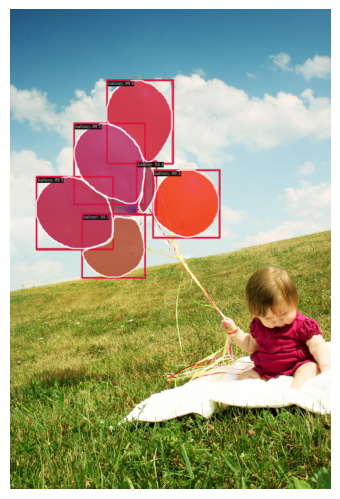

In [12]:
from mmengine.visualization import Visualizer
# get built visualizer
visualizer_now = Visualizer.get_current_instance()
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer_now.dataset_meta = model.dataset_meta
# show the results
visualizer_now.add_datasample(
    'new_result',
    img,
    data_sample=new_result,
    draw_gt=False,
    wait_time=0,
    out_file=None,
    pred_score_thr=0.5
)
visualizer_now.show()